### This notebook is used to solve the regression probelm of our dataset. The problem statement focuses on predicting the 10 scale rating score using the rest of the attributes

### We will buliding traditional machine learning model as well as state of the art neural network

<h3>Student Name : Laxman Kumar <br> Subject Name : IST 736 Text Mining <br> University : Syracuse University <br> Professor : Prof Yingya Li</h3>

#### Resouces used are https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018

# Building Traditional Machine Learning model

In [29]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC,SVC,SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from time import time

import nltk
%matplotlib inline

## Loading the cleaned data

In [2]:
df = pd.read_csv("cleaned.csv")

### Customized function for confusion matrix

In [3]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Splitting the data into train, test and validation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['rating'], test_size=0.2, random_state=0)

## Initialising the vectorizer.

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
countVectorizer = CountVectorizer(binary=False, min_df = 20, stop_words = stop_words, analyzer = 'word',ngram_range=(1,2))
countVector_train = countVectorizer.fit_transform(X_train)
countVector_val = countVectorizer.transform(X_test)

In [7]:
tfidfVectorizer = TfidfVectorizer(min_df = 20, stop_words = stop_words, analyzer = 'word',ngram_range=(1,2))
tfidfVector_train = tfidfVectorizer.fit_transform(X_train)
tfidfVector_train = tfidfVectorizer.transform(X_test)

## Building and comparing different models

### Customized function for calculating the accuracy of a model

In [8]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

### Function for generating report and important features

In [9]:
def GenerateReport(Ytest,y_pred,labels):
    print("--------CONFUSION MATRIX-----------")
    print(confusion_matrix(Ytest, y_pred, labels=labels))
    print()
    print("---------EVALUATION REPORT----------")
    print(classification_report(Ytest, y_pred))

def show_most_and_least_informative_features(vectorizer, clf, class_idx=0, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[class_idx], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[-n:])
    
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_2, fn_2, coef_1, fn_1))

### Generating report for three models with their default hyperparameters

In [12]:
names = ["Linear SVC", "Multinomial NB", "Bernoulli NB"]
classifiers = [LinearSVC(),MultinomialNB(),BernoulliNB()]

zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
tvec1 = CountVectorizer()
def classifier_comparator(vectorizer=tvec1,  stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', c)])
        print("Validation result for {}".format(n))
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,clf_accuracy,tt_time))
        #print(show_most_and_least_informative_features(tvec1,nb))
    return result

#trigram_result = classifier_comparator(ngram_range=(1,1))
#trigram_result = classifier_comparator(ngram_range=(1,2))
trigram_result = classifier_comparator(ngram_range=(1,3))

Validation result for Linear SVC
null accuracy: 100.00%
accuracy score: 67.77%
model is 32.23% less accurate than null accuracy
train and test time: 1789.11s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
null accuracy: 100.00%
accuracy score: 52.60%
model is 47.40% less accurate than null accuracy
train and test time: 105.12s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
null accuracy: 100.00%
accuracy score: 38.70%
model is 61.30% less accurate than null accuracy
train and test time: 101.95s
--------------------------------------------------------------------------------


After running several combination of vectorizer and ngram range Count vectorizer with ngram range of 1-3 gives the best result.

### Running the best model with different combination of hyperparameters

In [13]:
countVectorizer = CountVectorizer(binary=False,  stop_words = stop_words, analyzer = 'word',ngram_range=(1,3))
countVector_train = countVectorizer.fit_transform(X_train)
countVector_val = countVectorizer.transform(X_test)

### Multinomial Best and least features

In [14]:
mnb = MultinomialNB()
mnb.fit(countVector_train, y_train)
y_pred_class = mnb.predict(countVector_val)

metrics.accuracy_score(y_test, y_pred_class)

0.5851120850017341

In [15]:
show_most_and_least_informative_features(countVectorizer,mnb)

	-7.3887	get            		-15.6805	00 00 06       
	-7.3829	side           		-15.6805	00 00 afternoon
	-7.3494	took           		-15.6805	00 00 break    
	-7.3395	started        		-15.6805	00 00 exhausted
	-7.3272	months         		-15.6805	00 00 getting  
	-7.2977	days           		-15.6805	00 00 past     
	-7.2127	like           		-15.6805	00 00 reason   
	-7.1124	pain           		-15.6805	00 00 rest     
	-7.0895	taking         		-15.6805	00 00 side     
	-7.0611	day            		-15.6805	00 00 starting 


### BernoulliNB Best and least features

In [16]:
bnb = BernoulliNB()
bnb.fit(countVector_train, y_train)
y_pred_class = bnb.predict(countVector_val)
metrics.accuracy_score(y_test, y_pred_class)

0.3624239366901031

In [17]:
show_most_and_least_informative_features(countVectorizer,bnb)

	-1.6544	side           		-9.7500	00 00 06       
	-1.6535	started        		-9.7500	00 00 afternoon
	-1.6481	pain           		-9.7500	00 00 break    
	-1.6357	months         		-9.7500	00 00 exhausted
	-1.6330	never          		-9.7500	00 00 getting  
	-1.6039	days           		-9.7500	00 00 past     
	-1.5841	took           		-9.7500	00 00 reason   
	-1.5023	like           		-9.7500	00 00 rest     
	-1.4757	day            		-9.7500	00 00 side     
	-1.4072	taking         		-9.7500	00 00 starting 


### Linear SVM

In [18]:
nb = LinearSVC(C=1.5,max_iter=1500)
nb.fit(countVector_train, y_train)
y_pred_class = nb.predict(countVector_val)
metrics.accuracy_score(y_test, y_pred_class)

C:\Users\laxma\.conda\envs\Python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6702084055869092

In [19]:
show_most_and_least_informative_features(countVectorizer,nb)

	1.0209	positive effect		-1.0931	work well      
	1.0598	insomnia nausea		-0.9968	work insomnia  
	1.0654	anaphylaxis    		-0.9613	worked first time
	1.0796	heartbroken    		-0.9281	work night     
	1.0884	worl           		-0.8822	generic work   
	1.1042	sickening      		-0.8347	didnt work     
	1.1232	much allergies 		-0.8011	work chronic pain
	1.2095	worked first   		-0.7066	bad stomach upset
	1.3191	bad best       		-0.6950	work good      
	1.3652	good enough    		-0.6859	taken wide     


In [20]:
labels=['1','2','3','4','5','6','7','8','9','10']

In [21]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.67      0.82      0.73      4120
           2       0.68      0.51      0.58      1371
           3       0.64      0.51      0.57      1319
           4       0.69      0.52      0.59       983
           5       0.66      0.52      0.58      1599
           6       0.62      0.51      0.56      1231
           7       0.65      0.52      0.58      1818
           8       0.61      0.55      0.58      3757
           9       0.63      0.60      0.61      5473
          10       0.72      0.82      0.77     10046

    accuracy                           0.67     31717
   macro avg       0.66      0.59      0.62     31717
weighted avg       0.67      0.67      0.66     31717



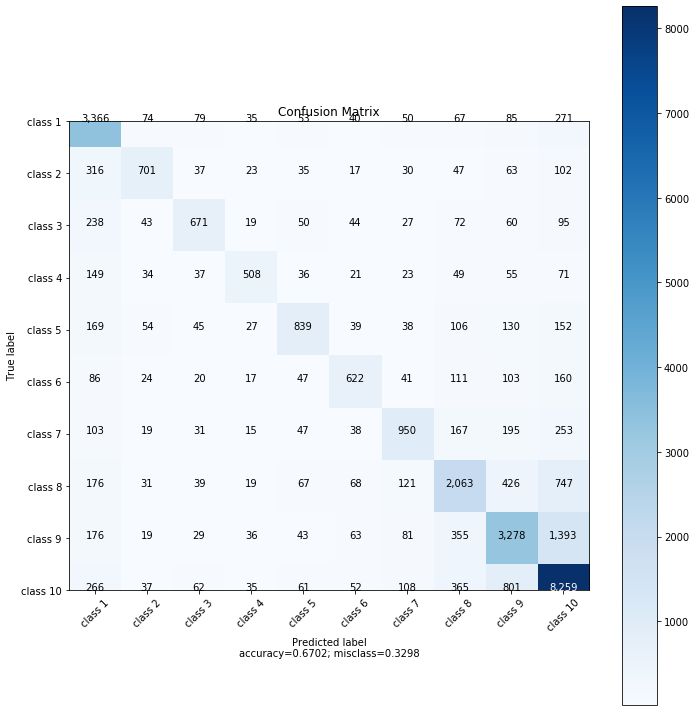

In [25]:
cm = confusion_matrix(y_pred=y_pred_class, y_true=y_test)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ["class 1", "class 2", "class 3", "class 4", "class 5", 
                                                        "class 6","class 7","class 8","class 9","class 10"],
                      title        = "Confusion Matrix")

# Bulding a Neural Network

In [ ]:
import numpy as np

In [26]:
import keras 
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from keras.utils.np_utils import to_categorical 
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, confusion_matrix, recall_score

Using TensorFlow backend.


## Splitting the data into train, test and validation

In [27]:
x_train, x_valid, y_train, y_valid = train_test_split(df['review'], df['rating'], test_size=0.2, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, test_size=0.5, random_state=42)

## Preparing data for neural network

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
vectorizer = TfidfVectorizer(ngram_range=(1,2))

x_train_vectors = vectorizer.fit_transform(x_train)
x_valid_vectors = vectorizer.transform(x_valid)
x_test_vectors = vectorizer.transform(x_test)

selector = SelectKBest(f_classif, k=min(1000, x_train_vectors.shape[1]))
selector.fit(x_train_vectors, y_train)

x_train_vectors = selector.transform(x_train_vectors).astype('float32')
x_valid_vectors = selector.transform(x_valid_vectors).astype('float32')
x_test_vectors = selector.transform(x_test_vectors).astype('float32')

new_x_train = np.array(x_train_vectors)
new_x_valid = np.array(x_train_vectors)

In [31]:
y_train_one_hot = to_categorical(y_train)
y_valid_one_hot = to_categorical(y_valid)

## Building the neural network model

In [32]:
model_mlp3 = keras.models.Sequential()

model_mlp3.add(keras.layers.Dense(1024, input_shape=(1000,)))
model_mlp3.add(keras.layers.Activation('relu'))

model_mlp3.add(keras.layers.Dense(512))
model_mlp3.add(keras.layers.Activation('relu'))

model_mlp3.add(keras.layers.Dense(256, activation='relu'))
model_mlp3.add(keras.layers.Dense(11, activation='sigmoid'))

model_mlp3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mlp3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              1025024   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 11)                2827      
Total params: 1,683,979
Trainable params: 1,683,979
Non-trainable params: 0
____________________________________________

### Training the neural net using train set and validation set

In [33]:
history3 = model_mlp3.fit(x_train_vectors, y_train_one_hot, epochs=25, batch_size=64, validation_data=(x_valid_vectors, y_valid_one_hot))

Train on 126867 samples, validate on 15859 samples
Epoch 1/25
126867/126867 [==============================] - 97s 762us/step - loss: 1.6260 - accuracy: 0.4199 - val_loss: 1.5772 - val_accuracy: 0.4317
Epoch 2/25
126867/126867 [==============================] - 93s 731us/step - loss: 1.5064 - accuracy: 0.4535 - val_loss: 1.5094 - val_accuracy: 0.4548
Epoch 3/25
126867/126867 [==============================] - 91s 716us/step - loss: 1.3098 - accuracy: 0.5127 - val_loss: 1.4675 - val_accuracy: 0.4831
Epoch 4/25
126867/126867 [==============================] - 82s 643us/step - loss: 1.0118 - accuracy: 0.6233 - val_loss: 1.4981 - val_accuracy: 0.5230
Epoch 5/25
126867/126867 [==============================] - 86s 678us/step - loss: 0.7065 - accuracy: 0.7439 - val_loss: 1.6427 - val_accuracy: 0.5656
Epoch 6/25
126867/126867 [==============================] - 103s 810us/step - loss: 0.4803 - accuracy: 0.8302 - val_loss: 1.7961 - val_accuracy: 0.6031
Epoch 7/25
126867/126867 [================

### Ploting the accuracy and loss

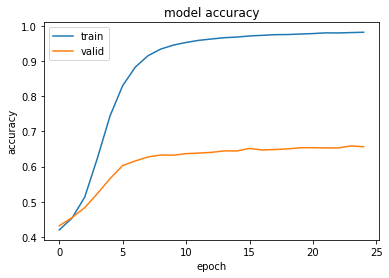

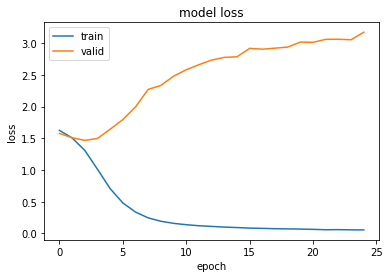

In [34]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Displaying the evaluation metrics

In [35]:
y_pred2_3 = model_mlp3.predict_classes(x_test_vectors)
print(classification_report(y_test, y_pred2_3, target_names=["class 1", "class 2", "class 3", "class 4", "class 5", "class 6","class 7","class 8","class 9","class 10"]))

              precision    recall  f1-score   support

     class 1       0.68      0.80      0.73      2101
     class 2       0.63      0.53      0.57       661
     class 3       0.56      0.54      0.55       685
     class 4       0.55      0.47      0.51       487
     class 5       0.49      0.56      0.53       790
     class 6       0.60      0.49      0.54       646
     class 7       0.62      0.53      0.57       906
     class 8       0.59      0.60      0.60      1866
     class 9       0.66      0.57      0.61      2686
    class 10       0.75      0.79      0.77      5030

    accuracy                           0.66     15858
   macro avg       0.61      0.59      0.60     15858
weighted avg       0.66      0.66      0.66     15858



### Confusion Metrics

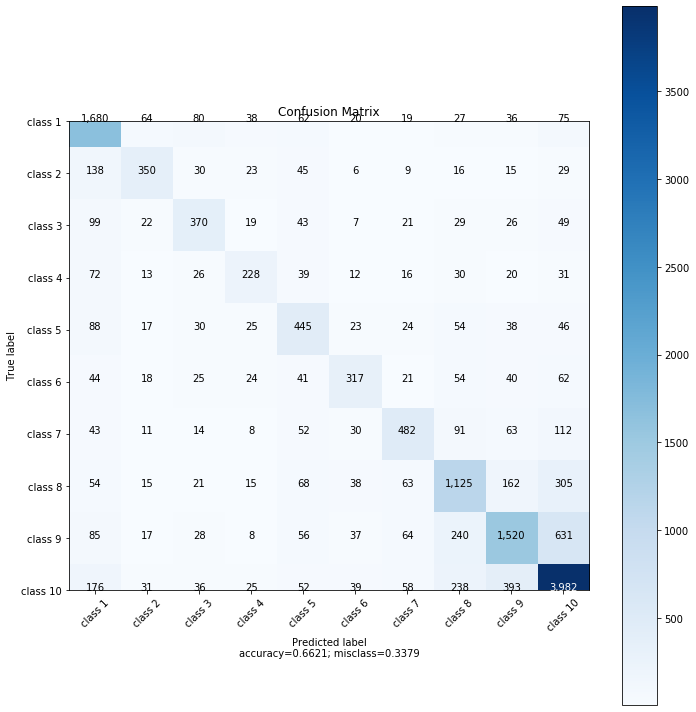

In [36]:
cm2_3 = confusion_matrix(y_pred=y_pred2_3, y_true=y_test)

plot_confusion_matrix(cm           = cm2_3, 
                      normalize    = False,
                      target_names = ["class 1", "class 2", "class 3", "class 4", "class 5", 
                                                        "class 6","class 7","class 8","class 9","class 10"],
                      title        = "Confusion Matrix")